In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import pandas as pd
import numpy as np
import torch
import collections, re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.util import ngrams
from nltk.tokenize import RegexpTokenizer
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
!pip3 install nltk
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from keras.layers import  CuDNNLSTM 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df1=pd.read_csv("/content/drive/My Drive/NLP project/clean_data.csv",encoding='latin-1') #you need to change the path
df2=pd.read_csv("/content/drive/My Drive/NLP project/clean_data2.csv",encoding='latin-1') #you need to change the path
clean_data=df1.copy() #

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

train_indices, test_indices, y_train, y_test = train_test_split(np.arange(len(clean_data)), clean_data['fraudulent'],
                                                    stratify=clean_data['fraudulent'], 
                                                    test_size=0.3,random_state=0)
reduced_train_indices, val_indices, y_reduced_train, y_valid = train_test_split(train_indices, clean_data.loc[train_indices]['fraudulent'],
                                                    stratify=clean_data.loc[train_indices]['fraudulent'], 
                                                    test_size=0.2,random_state=0)

In [0]:
from keras.layers import concatenate
from keras import Sequential, Model
from sklearn.metrics import classification_report, confusion_matrix,f1_score,accuracy_score, precision_score,recall_score
non_text= clean_data.drop(['title', 'job_id', 'company_profile','description','fraudulent'], axis=1).to_numpy()

In [0]:
max_fatures = 3000
clean_data['company_profile']=clean_data['company_profile'].astype(str)
clean_data['description']=clean_data['description'].astype(str)
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(clean_data['company_profile'].values)
X1 = tokenizer.texts_to_sequences(clean_data['company_profile'].values)
X1 = pad_sequences(X1)
X1_train=X1[reduced_train_indices]
X1_val=X1[val_indices]
X1_test=X1[test_indices]

In [0]:
tokenizer1 = Tokenizer(num_words=max_fatures, split=' ')
tokenizer1.fit_on_texts(clean_data['description'].values)
X1_des = tokenizer.texts_to_sequences(clean_data['description'].values)
X1_des = pad_sequences(X1_des)
X1_train_des=X1_des[reduced_train_indices]
X1_val_des=X1_des[val_indices]
X1_test_des=X1_des[test_indices]

In [0]:
Y1 = pd.get_dummies(clean_data['fraudulent']).values
Y1_train=Y1[reduced_train_indices]
Y1_val=Y1[val_indices]
Y1_test=Y1[test_indices]

In [10]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(np.array(reduced_train_indices).reshape(-1, 1), clean_data.iloc[reduced_train_indices]['fraudulent'])
X_resampled=X_resampled.flatten()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
from keras import backend as K
import tensorflow as tf
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, 395)          0                                            
__________________________________________________________________________________________________
embedding_2_input (InputLayer)  (None, 913)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 395, 1000)    3000000     embedding_1_input[0][0]          
__________________________________________________________________________________________________
embedding_2 (Emb

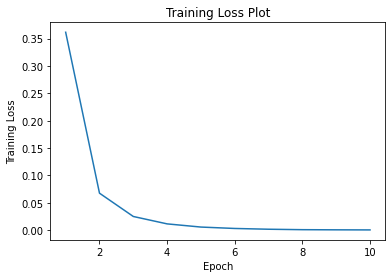

0.7663551401869158
[[2372   11]
 [  39   82]]
0.9800319488817891
0.8817204301075269
0.6776859504132231


In [12]:
embed_dim = 1000
lstm_out = 200
model1 = Sequential()
model1.add(Embedding(max_fatures, embed_dim,input_length = X1.shape[1]))
model1.add(CuDNNLSTM(lstm_out))
model1.add(Dense(20,activation='softmax'))
model1.add(Dense(2,activation='softmax'))

model2 = Sequential()
model2.add(Embedding(max_fatures, embed_dim,input_length = X1_des.shape[1]))
model2.add(CuDNNLSTM(lstm_out))
model2.add(Dense(20,activation='softmax'))
model2.add(Dense(2,activation='softmax'))

model3 = Sequential()
model3.add(Dense(200,input_dim=non_text.shape[1],activation='relu'))
model3.add(Dense(100,activation='relu'))
model3.add(Dense(2,activation='sigmoid'))
#model3.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

model_concat = concatenate([model1.output, model2.output, model3.output], axis=-1)
#model_concat = Dense(80, activation='sigmoid')(model_concat)
model_concat = Dense(50, activation='sigmoid')(model_concat)
model_concat = Dense(2, activation='softmax')(model_concat)
model= Model(inputs=[model1.input, model2.input,model3.input], outputs=model_concat)
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy',f1])
# model.compile(loss = f1_loss, optimizer='adam',metrics = ['accuracy',f1])
model.summary()
history=model.fit([X1[X_resampled],X1_des[X_resampled],non_text[X_resampled]], pd.get_dummies(clean_data['fraudulent']).values[X_resampled], epochs = 10, batch_size=40,workers=-1)

training_loss = history.history['loss']
epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss)
plt.title('Training Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show();

y_pred=model.predict([X1_val,X1_val_des,non_text[val_indices]], batch_size = 40)
y_pred1=np.argmax(y_pred,axis=1)
Y1_val1=np.argmax(Y1_val,axis=1)
print(f1_score(Y1_val1, y_pred1))
print(confusion_matrix(Y1_val1, y_pred1))
print(accuracy_score(Y1_val1, y_pred1))
print(precision_score(Y1_val1, y_pred1))
print(recall_score(Y1_val1, y_pred1))

In [0]:
max_fatures = 3000
clean_data['company_profile']=clean_data['company_profile'].astype(str)
clean_data['description']=clean_data['description'].astype(str)
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(clean_data['company_profile'].values)
X1 = tokenizer.texts_to_sequences(clean_data['company_profile'].values)
X1 = pad_sequences(X1)
X1_train=X1[train_indices]
X1_test=X1[test_indices]

In [0]:
tokenizer1 = Tokenizer(num_words=max_fatures, split=' ')
tokenizer1.fit_on_texts(clean_data['description'].values)
X1_des = tokenizer.texts_to_sequences(clean_data['description'].values)
X1_des = pad_sequences(X1_des)
X1_train_des=X1_des[train_indices]
X1_test_des=X1_des[test_indices]

In [0]:
Y1 = pd.get_dummies(clean_data['fraudulent']).values
Y1_train=Y1[train_indices]
Y1_test=Y1[test_indices]

In [16]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(np.array(train_indices).reshape(-1, 1), clean_data.iloc[train_indices]['fraudulent'])
X_resampled=X_resampled.flatten()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_3_input (InputLayer)  (None, 395)          0                                            
__________________________________________________________________________________________________
embedding_4_input (InputLayer)  (None, 913)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 395, 1000)    3000000     embedding_3_input[0][0]          
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 913, 1000)    3000000     embedding_4_input[0][0]          
____________________________________________________________________________________________

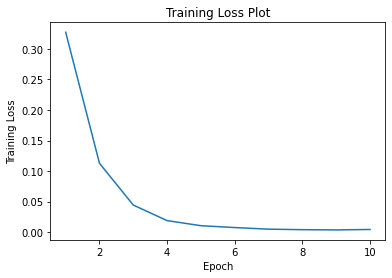

0.7842323651452282
[[5071   33]
 [  71  189]]
0.9806114839671887
0.8513513513513513
0.7269230769230769


In [17]:
embed_dim = 1000
lstm_out = 200
model11 = Sequential()
model11.add(Embedding(max_fatures, embed_dim,input_length = X1.shape[1]))
model11.add(CuDNNLSTM(lstm_out))
model11.add(Dense(20,activation='softmax'))
model11.add(Dense(2,activation='softmax'))

model12 = Sequential()
model12.add(Embedding(max_fatures, embed_dim,input_length = X1_des.shape[1]))
model12.add(CuDNNLSTM(lstm_out))
model12.add(Dense(20,activation='softmax'))
model12.add(Dense(2,activation='softmax'))

model13 = Sequential()
model13.add(Dense(200,input_dim=non_text.shape[1],activation='relu'))
model13.add(Dense(100,activation='relu'))
model13.add(Dense(2,activation='sigmoid'))
#model3.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

model_concat1 = concatenate([model11.output, model12.output, model13.output], axis=-1)
#model_concat = Dense(80, activation='sigmoid')(model_concat)
model_concat1 = Dense(50, activation='sigmoid')(model_concat1)
model_concat1 = Dense(2, activation='softmax')(model_concat1)
model1= Model(inputs=[model11.input, model12.input,model13.input], outputs=model_concat1)
model1.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy',f1])
# model.compile(loss = f1_loss, optimizer='adam',metrics = ['accuracy',f1])
model1.summary()
history1=model1.fit([X1[X_resampled],X1_des[X_resampled],non_text[X_resampled]], pd.get_dummies(clean_data['fraudulent']).values[X_resampled], epochs = 10, batch_size=40,workers=-1)

training_loss = history1.history['loss']
epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss)
plt.title('Training Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show();

y_pred_test=model1.predict([X1_test,X1_test_des,non_text[test_indices]], batch_size = 40)
y_pred_test1=np.argmax(y_pred_test,axis=1)
Y1_test1=np.argmax(Y1_test,axis=1)
print(f1_score(Y1_test1, y_pred_test1))
print(confusion_matrix(Y1_test1, y_pred_test1))
print(accuracy_score(Y1_test1, y_pred_test1))
print(precision_score(Y1_test1, y_pred_test1))
print(recall_score(Y1_test1, y_pred_test1))